# 最適化結果の可視化ノートブック

このノートでは、出力CSV（例: `data/04_PlanningData/Clea/optimized_results_YYYYMMDD_YYYYMMDD.csv`）を指定して読み込み、ゾーン別に計画（set_temp, mode, fan_speed, numb_units_on など）と予報（outdoor_temp, solar_radiation）を可視化します。

手順:
- 入力セルでファイルパスを指定
- 自動でゾーン一覧を抽出し、選択UIからゾーンを選ぶ
- 時系列で複数KPIを重ね描画



In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# 日本語フォント設定（環境に応じて調整）
plt.rcParams['font.family'] = ['Hiragino Sans', 'IPAexGothic', 'Noto Sans CJK JP', 'Arial Unicode MS', 'TakaoGothic']
plt.rcParams['axes.unicode_minus'] = False

# プロジェクトルートをパスに追加（Jupyterでは__file__が無いのでCWDベース）
cwd = Path.cwd()
project_root = cwd.parent if cwd.name == 'notebooks' else cwd
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"Project root: {project_root}")



Project root: /Users/tomokiinoue/Desktop/workspace/AIrux8_opti_logic


In [2]:
import json

# カテゴリ逆引き辞書の読み込み（数値→名称）
CATEGORY_INV = {}
try:
    with open(project_root / 'category_mapping.json', 'r') as f:
        cat = json.load(f)
    # 逆引き化
    for k, mapping in cat.items():
        try:
            CATEGORY_INV[k] = {int(v): str(name) for name, v in mapping.items()}
        except Exception:
            # 数値化できない場合はそのまま
            CATEGORY_INV[k] = {v: str(name) for name, v in mapping.items()}
except Exception as e:
    print(f"⚠️ カテゴリ定義の読み込みに失敗: {e}")


⚠️ カテゴリ定義の読み込みに失敗: [Errno 2] No such file or directory: '/Users/tomokiinoue/Desktop/workspace/AIrux8_opti_logic/category_mapping.json'


In [3]:
from typing import List

import ipywidgets as widgets
from IPython.display import display, clear_output

# 入力UI
default_path = str(project_root / "data/04_PlanningData/Clea/optimized_results_20250929_20251004.csv")
file_input = widgets.Text(value=default_path, description='結果CSV:', layout=widgets.Layout(width='80%'))
load_button = widgets.Button(description='読み込み', button_style='primary')
zone_dropdown = widgets.Dropdown(options=[], description='ゾーン:')

# 期間フィルタ
start_dt = widgets.Text(value='', description='開始:')
end_dt = widgets.Text(value='', description='終了:')

ui = widgets.VBox([
    widgets.HBox([file_input, load_button]),
    widgets.HBox([zone_dropdown, start_dt, end_dt])
])

display(ui)

# データ保持
opt_df = None
zones: List[str] = []


def infer_zones(columns: List[str]) -> List[str]:
    zones = []
    for col in columns:
        if col.endswith('_set_temp'):
            zones.append(col.replace('_set_temp', ''))
    return sorted(zones)


def load_data(_):
    global opt_df, zones
    path = file_input.value.strip()
    if not os.path.exists(path):
        print(f"❌ ファイルが見つかりません: {path}")
        return
    try:
        df = pd.read_csv(path)
        # datetime 列
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
        elif 'Datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['Datetime'])
        else:
            raise ValueError('datetime列が見つかりません')
        # ゾーン推定
        zones = infer_zones(df.columns.tolist())
        if not zones:
            raise ValueError('ゾーン列が見つかりません (_set_temp が存在しません)')
        zone_dropdown.options = zones
        opt_df = df.sort_values('datetime').reset_index(drop=True)
        print(f"✅ 読み込み成功: {opt_df.shape}, ゾーン: {zones}")
    except Exception as e:
        print(f"❌ 読み込み失敗: {e}")


load_button.on_click(load_data)



In [4]:
def plot_zone(df: pd.DataFrame, zone: str, start: str = '', end: str = ''):
    if df is None or df.empty:
        print('❌ データが読み込まれていません')
        return
    cols_needed = [
        'datetime', 'forecast_outdoor_temp', 'forecast_solar_radiation',
        f'{zone}_set_temp', f'{zone}_mode', f'{zone}_fan_speed',
        f'{zone}_numb_units_on', f'{zone}_ac_on_off', f'{zone}_power',
        f'{zone}_indoor_temp'
    ]
    missing = [c for c in cols_needed if c not in df.columns]
    if missing:
        print(f"❌ 必須列が見つかりません: {missing}")
        return

    plot_df = df.copy()
    if start:
        plot_df = plot_df[plot_df['datetime'] >= pd.to_datetime(start)]
    if end:
        plot_df = plot_df[plot_df['datetime'] <= pd.to_datetime(end)]
    if plot_df.empty:
        print('⚠️ フィルタ後データが空です')
        return

    # 非運転時間のマスク（台数0 または ac_on_offがOFF）
    off_mask = (plot_df[f'{zone}_numb_units_on'].fillna(0) <= 0) | (
        plot_df.get(f'{zone}_ac_on_off', 'OFF').astype(str).str.upper() == 'OFF'
    )

    sns.set_style('whitegrid')
    fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

    # 背景に非運転時間を薄いグレーで塗る関数
    def shade_off(ax):
        if off_mask.any():
            # 連続区間で塗りつぶし
            spans = []
            current = None
            for t, is_off in zip(plot_df['datetime'], off_mask):
                if is_off and current is None:
                    current = t
                elif not is_off and current is not None:
                    spans.append((current, t))
                    current = None
            if current is not None:
                spans.append((current, plot_df['datetime'].iloc[-1]))
            for start_t, end_t in spans:
                ax.axvspan(start_t, end_t, color='#eeeeee', alpha=0.6, zorder=0)

    # 1) 予報: 外気温 / 日射
    ax = axes[0]
    shade_off(ax)
    l1, = ax.plot(plot_df['datetime'], plot_df['forecast_outdoor_temp'], label='Outdoor Temp (forecast)', color='tab:orange')
    ax2 = ax.twinx()
    l2, = ax2.plot(plot_df['datetime'], plot_df['forecast_solar_radiation'], label='Solar Radiation (forecast)', color='tab:olive', alpha=0.6)
    ax.set_ylabel('Temp [°C]')
    ax2.set_ylabel('Solar [W/m²]')
    ax.set_title(f'{zone} - Forecast Weather')
    ax.legend(handles=[l1, l2], loc='upper left')

    # 2) 提案: 台数・電力
    ax = axes[1]
    shade_off(ax)
    l3, = ax.step(plot_df['datetime'], plot_df[f'{zone}_numb_units_on'], where='mid', label='Units ON', color='tab:blue')
    ax2 = ax.twinx()
    l4, = ax2.plot(plot_df['datetime'], plot_df[f'{zone}_power'], label='Power (hist adj.)', color='tab:red', alpha=0.7)
    ax.set_ylabel('Units [count]')
    ax2.set_ylabel('Power [kWh]')
    ax.set_title(f'{zone} - Units and Power')
    ax.legend(handles=[l3, l4], loc='upper left')

    # 3) 設定温度 / 室温
    ax = axes[2]
    shade_off(ax)
    l5, = ax.step(plot_df['datetime'], plot_df[f'{zone}_set_temp'], where='mid', label='Set Temp', color='tab:purple')
    handles = [l5]
    if f'{zone}_indoor_temp' in plot_df.columns:
        l6, = ax.plot(plot_df['datetime'], plot_df[f'{zone}_indoor_temp'], label='Indoor Temp (hist)', color='tab:green', alpha=0.7)
        handles.append(l6)
    ax.set_ylabel('Temp [°C]')
    ax.set_title(f'{zone} - Set/Indoor Temperature')
    ax.legend(handles=handles, loc='upper left')

    # 4) カテゴリ（mode, fan）
    ax = axes[3]
    shade_off(ax)
    # モードは文字列の場合があるため可視化用に数値化（凡例はラベルで補足）
    mode_series = plot_df[f'{zone}_mode']
    mode_numeric = pd.Categorical(mode_series).codes
    l7, = ax.step(plot_df['datetime'], mode_numeric, where='mid', label='Mode (cat)', color='tab:gray')
    ax2 = ax.twinx()
    fan_series = plot_df[f'{zone}_fan_speed']
    fan_numeric = pd.Categorical(fan_series).codes
    l8, = ax2.step(plot_df['datetime'], fan_numeric, where='mid', label='Fan (cat)', color='tab:brown', alpha=0.8)
    ax.set_ylabel('Mode (cat)')
    ax2.set_ylabel('Fan (cat)')
    ax.set_title(f'{zone} - Mode/Fan (categorical)')
    ax.legend(handles=[l7, l8], loc='upper left')

    # 凡例・体裁
    for a in axes:
        a.grid(True, alpha=0.2)
    # x軸フォーマットを mm/dd\n(%A) に設定（下段の軸に適用）
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n(%A)'))
    # 1日毎に主目盛を配置（必要なら自動に変更可）
    axes[-1].xaxis.set_major_locator(mdates.DayLocator())
    fig.suptitle(f'Zone Visualization: {zone}', fontsize=14)
    plt.tight_layout()
    plt.show()


# ゾーン選択で描画
plot_button = widgets.Button(description='プロット', button_style='')

def on_plot(_):
    if opt_df is None:
        print('❌ 先に結果CSVを読み込んでください')
        return
    z = zone_dropdown.value
    s = start_dt.value.strip()
    e = end_dt.value.strip()
    plot_zone(opt_df, z, s, e)

plot_button.on_click(on_plot)
display(plot_button)



Button(description='プロット', style=ButtonStyle())

In [5]:
from matplotlib.patches import Patch

def plot_zone_plan_styled(df: pd.DataFrame, zone: str, start: str = '', end: str = ''):
    # 必須列確認
    cols_needed = [
        'datetime', 'forecast_outdoor_temp',
        f'{zone}_set_temp', f'{zone}_mode', f'{zone}_fan_speed',
        f'{zone}_numb_units_on', f'{zone}_ac_on_off', f'{zone}_power',
        f'{zone}_indoor_temp'
    ]
    missing = [c for c in cols_needed if c not in df.columns]
    if missing:
        print(f"❌ 必須列が見つかりません: {missing}")
        return

    zdf = df.copy()
    if start:
        zdf = zdf[zdf['datetime'] >= pd.to_datetime(start)]
    if end:
        zdf = zdf[zdf['datetime'] <= pd.to_datetime(end)]
    if zdf.empty:
        print('⚠️ フィルタ後データが空です')
        return
    zdf = zdf.sort_values('datetime').reset_index(drop=True)

    x = zdf['datetime']
    x_min, x_max = x.min(), x.max()

    # ON/OFF判定
    units = zdf[f'{zone}_numb_units_on'].fillna(0).astype(float)
    ac_raw = zdf[f'{zone}_ac_on_off']
    # ac_on_off は 'ON'/'OFF' または 1/0 を想定
    try:
        status = pd.to_numeric(ac_raw, errors='coerce').fillna(0).astype(float)
    except Exception:
        status = ac_raw.astype(str).str.upper().map({'ON': 1.0, 'OFF': 0.0}).fillna(0.0)
    on_mask = (units > 0) & (status > 0)
    off_mask = ~on_mask

    # サンプリング間隔（bar 幅に使用）
    dt = zdf['datetime'].diff().median()
    if pd.isna(dt) or dt <= pd.Timedelta(0):
        dt = pd.Timedelta(hours=1)
    width_days = dt / np.timedelta64(1, 'D')

    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

    def shade_off(ax):
        if off_mask.any():
            for t, is_off in zip(x, off_mask):
                if is_off:
                    ax.axvspan(t, t + dt, color='whitesmoke', alpha=1, zorder=0)

    # 上段: Power(bar, y1) + Temps(y2)
    ax = axes[0]
    shade_off(ax)
    handles = []; labels = []

    # Power（棒・左端基準）
    y_pow = zdf[f'{zone}_power'].astype(float)
    ax.bar(x, y_pow, width=width_days, align='edge', color='gold', alpha=0.25, linewidth=0, label='Power', zorder=2)
    handles.append(Patch(facecolor='gold', edgecolor='none', alpha=0.25, label='Power')); labels.append('Power')
    if np.isfinite(np.nanmax(y_pow)):
        ax.set_ylim(0, np.nanmax(y_pow) * 1.1)

    # Temps（右軸）
    ax2 = ax.twinx()
    # Outdoor
    y_out = zdf['forecast_outdoor_temp'].astype(float)
    h_out, = ax2.plot(x, y_out, color='slategrey', lw=2.0, alpha=0.9, label='Outdoor Temp', zorder=3, ls='dashed')
    handles.append(h_out); labels.append('Outdoor Temp')
    # Set（ONのみ、step-post）
    y_set = zdf[f'{zone}_set_temp'].astype(float).where(on_mask, np.nan)
    h_set = ax2.step(x, y_set, where='post', color='dodgerblue', lw=2.0, label='Set Temp', zorder=3, linestyle='dotted')[0]
    handles.append(h_set); labels.append('Set Temp')
    # Indoor（任意）
    if f'{zone}_indoor_temp' in zdf.columns:
        y_ind = zdf[f'{zone}_indoor_temp'].astype(float)
        h_ind, = ax2.plot(x, y_ind, color='dodgerblue', lw=2.0, alpha=0.9, label='Indoor Temp', zorder=3, ls='solid')
        handles.append(h_ind); labels.append('Indoor Temp')

    temps = []
    for s in [y_out, y_set, zdf.get(f'{zone}_indoor_temp', pd.Series(dtype=float))]:
        try:
            vals = pd.to_numeric(s, errors='coerce')
            temps += list(vals.dropna().values)
        except Exception:
            pass
    if temps:
        ax2.set_ylim(min(temps) - 1.0, max(temps) + 1.0)

    ax.set_title(f'{zone} - Power & Temperatures', loc='left')
    ax.set_ylabel('Power [kWh]'); ax2.set_ylabel('Temp [°C]')
    if handles:
        ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.12, 1), handleheight=0.5, frameon=True)
    ax.set_xlim(x_min, x_max + dt)

    # 下段: Units(bar, y1) + Mode(y2) + Fan(右オフセット) + ON/OFF(左オフセット)
    ax = axes[1]
    shade_off(ax)
    handles = []; labels = []

    # Units（棒、ONのみ）
    ax.bar(x[on_mask], units[on_mask], width=width_days, align='edge', color='dodgerblue', alpha=0.25, linewidth=0, label='Units', zorder=2)
    handles.append(Patch(facecolor='dodgerblue', edgecolor='none', alpha=0.25, label='Units')); labels.append('Units')
    if np.isfinite(np.nanmax(units)):
        ax.set_ylim(0, max(int(np.nanmax(units)), 1) + 0.5)

    # 右（Mode）
    ax_mode = ax.twinx()
    # 右オフセット（Fan）
    ax_fan = ax.twinx(); ax_fan.spines['right'].set_position(('axes', 1.12))
    # 左オフセット（ON/OFF）
    ax_on = ax.twinx(); ax_on.spines['right'].set_position(('axes', -0.10)); ax_on.yaxis.set_label_position('left'); ax_on.yaxis.tick_left()

    for aux in [ax_mode, ax_fan, ax_on]:
        aux.grid(False); aux.set_facecolor('none')

    # Mode（ONのみ、step-post）
    y_mode_raw = zdf[f'{zone}_mode']
    try:
        y_mode = pd.to_numeric(y_mode_raw, errors='coerce')
        y_mode = y_mode.where(on_mask, np.nan).astype(float)
    except Exception:
        # 文字→カテゴリコード（欠損は -1 になるので NaN に置換）
        codes = pd.Categorical(y_mode_raw).codes
        y_mode = pd.Series(codes, index=zdf.index).replace(-1, np.nan).where(on_mask, np.nan).astype(float)
    h_mode = ax_mode.step(x, y_mode, where='post', color='tab:gray', lw=2.0, label='Mode', zorder=3)[0]
    handles.append(h_mode); labels.append('Mode')
    # 目盛（候補すべて、数値+名称）
    ticks_mode, labels_mode = [], []
    if 'A/C Mode' in CATEGORY_INV and len(CATEGORY_INV['A/C Mode']):
        inv = CATEGORY_INV['A/C Mode']
        for code in sorted(inv.keys()):
            ticks_mode.append(code); labels_mode.append(f"{code} {inv[code]}")
    else:
        vals = sorted(set(pd.to_numeric(y_mode_raw, errors='coerce').dropna().astype(int).tolist()))
        ticks_mode = vals; labels_mode = [str(v) for v in vals]
    if ticks_mode:
        ax_mode.set_yticks(ticks_mode); ax_mode.set_yticklabels(labels_mode)
        ax_mode.set_ylim(min(ticks_mode) - 0.5, max(ticks_mode) + 0.5)
        ax_mode.set_ylabel('Mode', rotation=90)

    # Fan（ONのみ、step-post）
    y_fan_raw = zdf[f'{zone}_fan_speed']
    try:
        y_fan = pd.to_numeric(y_fan_raw, errors='coerce')
        y_fan = y_fan.where(on_mask, np.nan).astype(float)
    except Exception:
        codes = pd.Categorical(y_fan_raw).codes
        y_fan = pd.Series(codes, index=zdf.index).replace(-1, np.nan).where(on_mask, np.nan).astype(float)
    h_fan = ax_fan.step(x, y_fan, where='post', color='tab:green', lw=2.0, label='Fan', zorder=3)[0]
    handles.append(h_fan); labels.append('Fan')
    ticks_fan, labels_fan = [], []
    if 'A/C Fan Speed' in CATEGORY_INV and len(CATEGORY_INV['A/C Fan Speed']):
        inv = CATEGORY_INV['A/C Fan Speed']
        for code in sorted(inv.keys()):
            ticks_fan.append(code); labels_fan.append(f"{code} {inv[code]}")
    else:
        vals = sorted(set(pd.to_numeric(y_fan_raw, errors='coerce').dropna().astype(int).tolist()))
        ticks_fan = vals; labels_fan = [str(v) for v in vals]
    if ticks_fan:
        ax_fan.set_yticks(ticks_fan); ax_fan.set_yticklabels(labels_fan)
        ax_fan.set_ylim(min(ticks_fan) - 0.5, max(ticks_fan) + 0.5)
        ax_fan.set_ylabel('Fan', rotation=90)

    # ON/OFF（候補すべて、数値+名称）
    y_on = units.copy(); y_on[~on_mask] = np.nan
    h_on = ax_on.step(x, y_on.clip(upper=1), where='post', color='tab:orange', lw=2.0, label='ON/OFF', zorder=3)[0]
    handles.append(h_on); labels.append('ON/OFF')
    ticks_on, labels_on = [], []
    if 'A/C ON/OFF' in CATEGORY_INV and len(CATEGORY_INV['A/C ON/OFF']):
        inv = CATEGORY_INV['A/C ON/OFF']
        for code in sorted(inv.keys()):
            ticks_on.append(code); labels_on.append(f"{code} {inv[code]}")
    else:
        ticks_on = [0, 1]; labels_on = ['0 OFF', '1 ON']
    ax_on.set_yticks(ticks_on); ax_on.set_yticklabels(labels_on)
    ax_on.set_ylim(min(ticks_on) - 0.25, max(ticks_on) + 0.25)
    ax_on.set_ylabel('ON/OFF', rotation=90)

    ax.set_title(f'{zone} - Units & Mode/Fan/ON-OFF', loc='left')
    ax.set_ylabel('Units')
    if handles:
        ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.12, 1), handleheight=0.5, frameon=True)
    ax.set_xlim(x_min, x_max + dt)

    # 体裁
    for a in axes:
        a.grid(True, alpha=0.2)
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n(%a)'))
    axes[-1].xaxis.set_major_locator(mdates.DayLocator())
    fig.suptitle(f'Plan Visualization: {zone}', fontsize=13, ha='left', x=0.01)
    plt.tight_layout()
    plt.show()


✅ 読み込み成功: (144, 75), ゾーン: ['Area 1', 'Area 2', 'Area 3', 'Area 4', 'Break Room', 'Meeting Room']


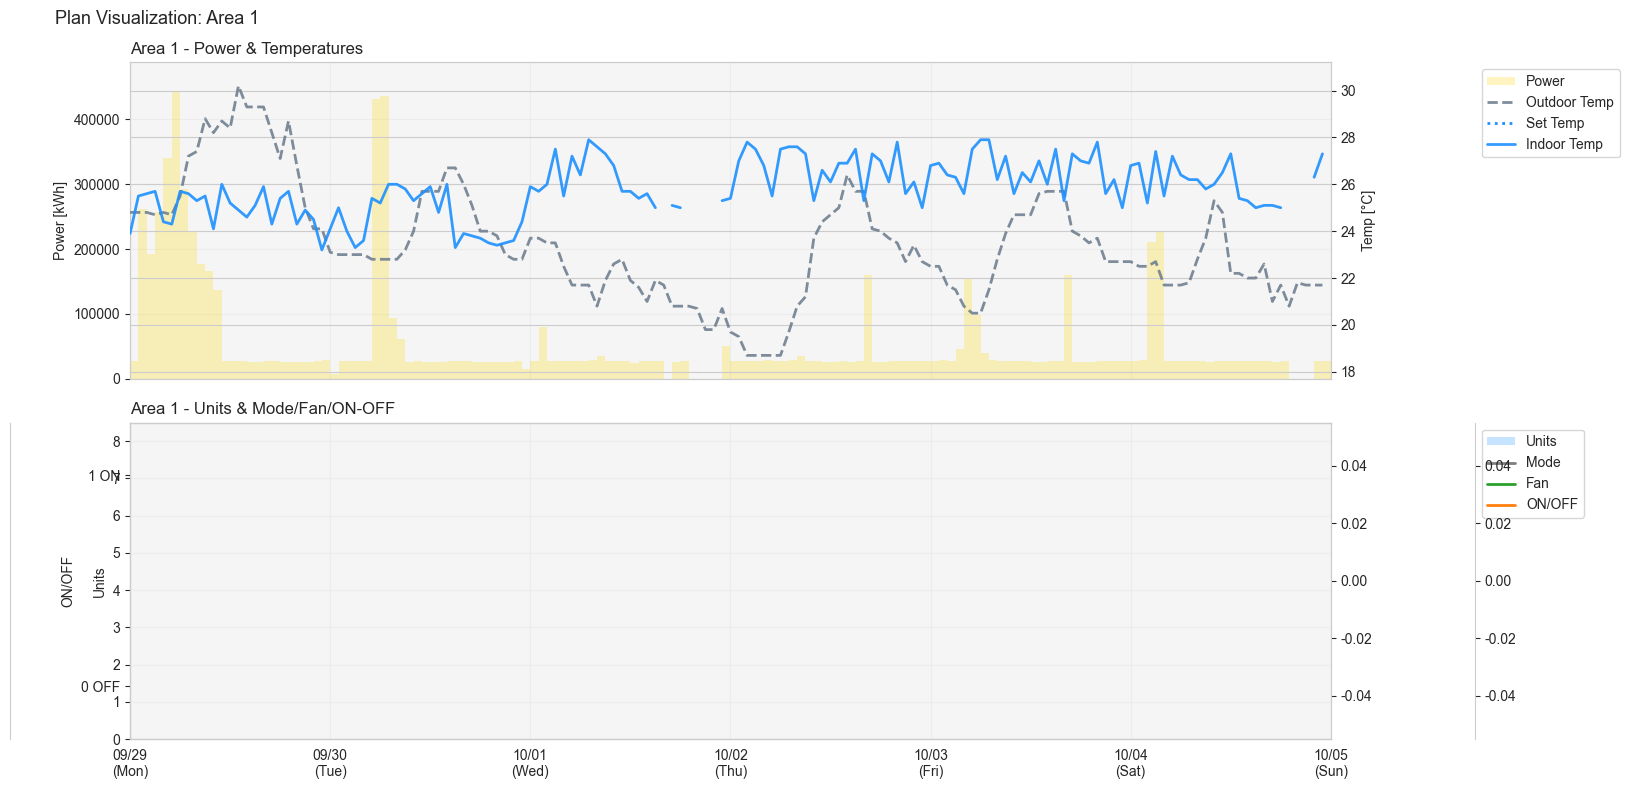

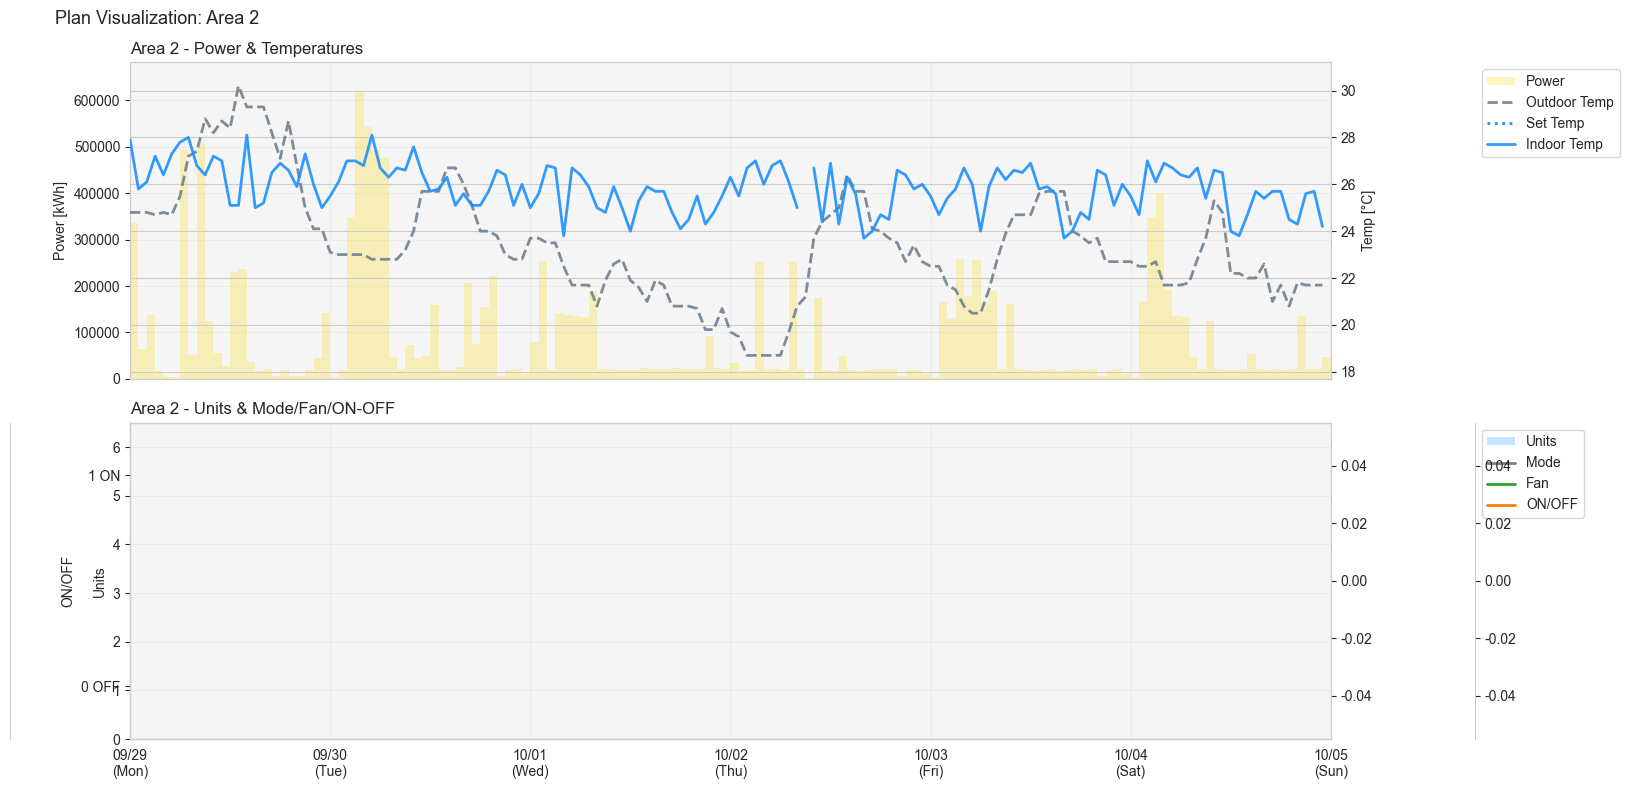

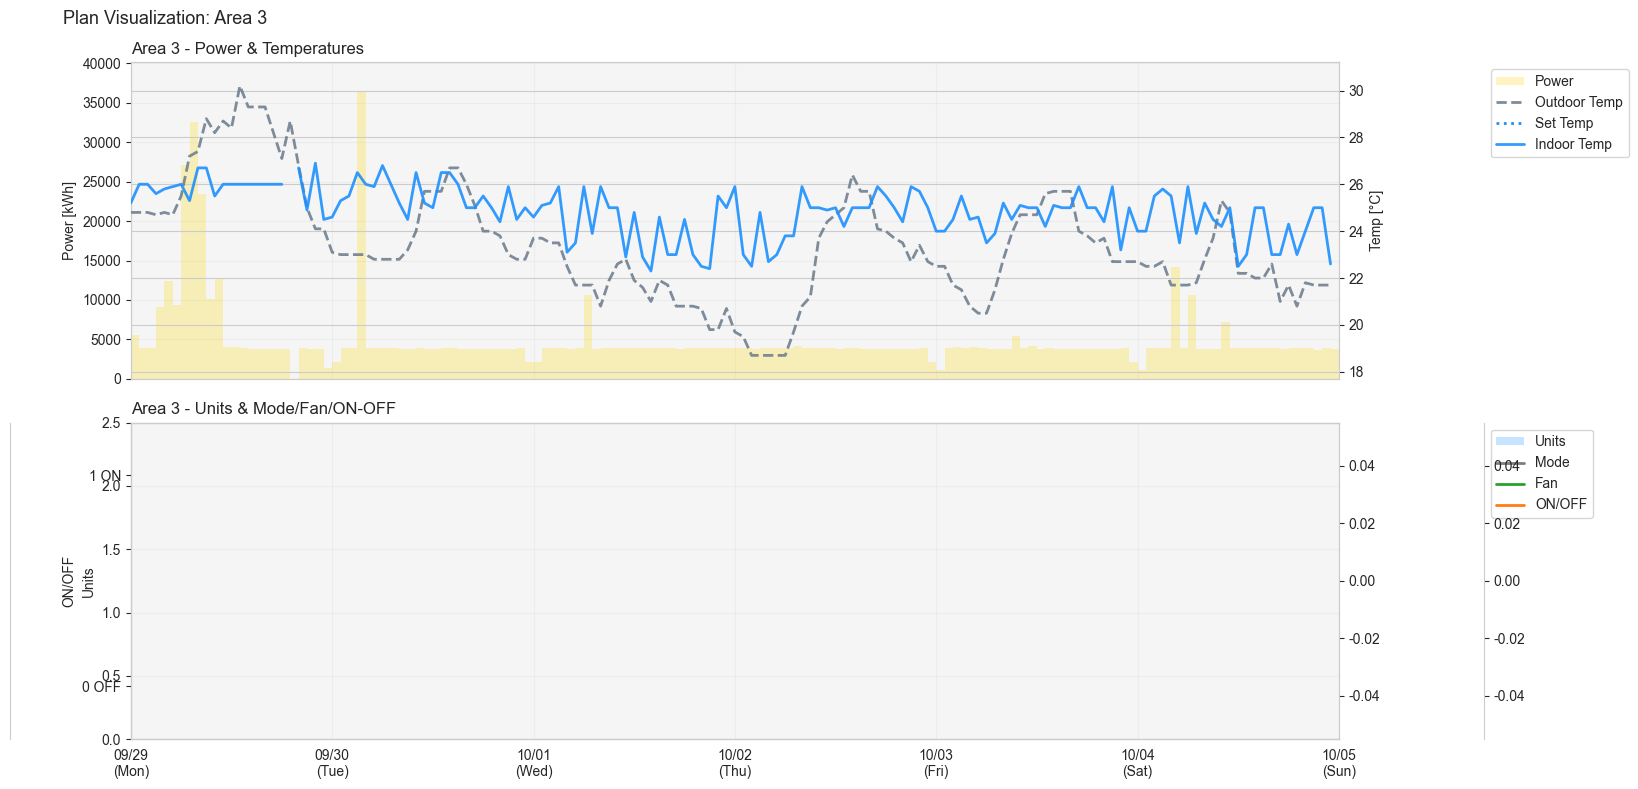

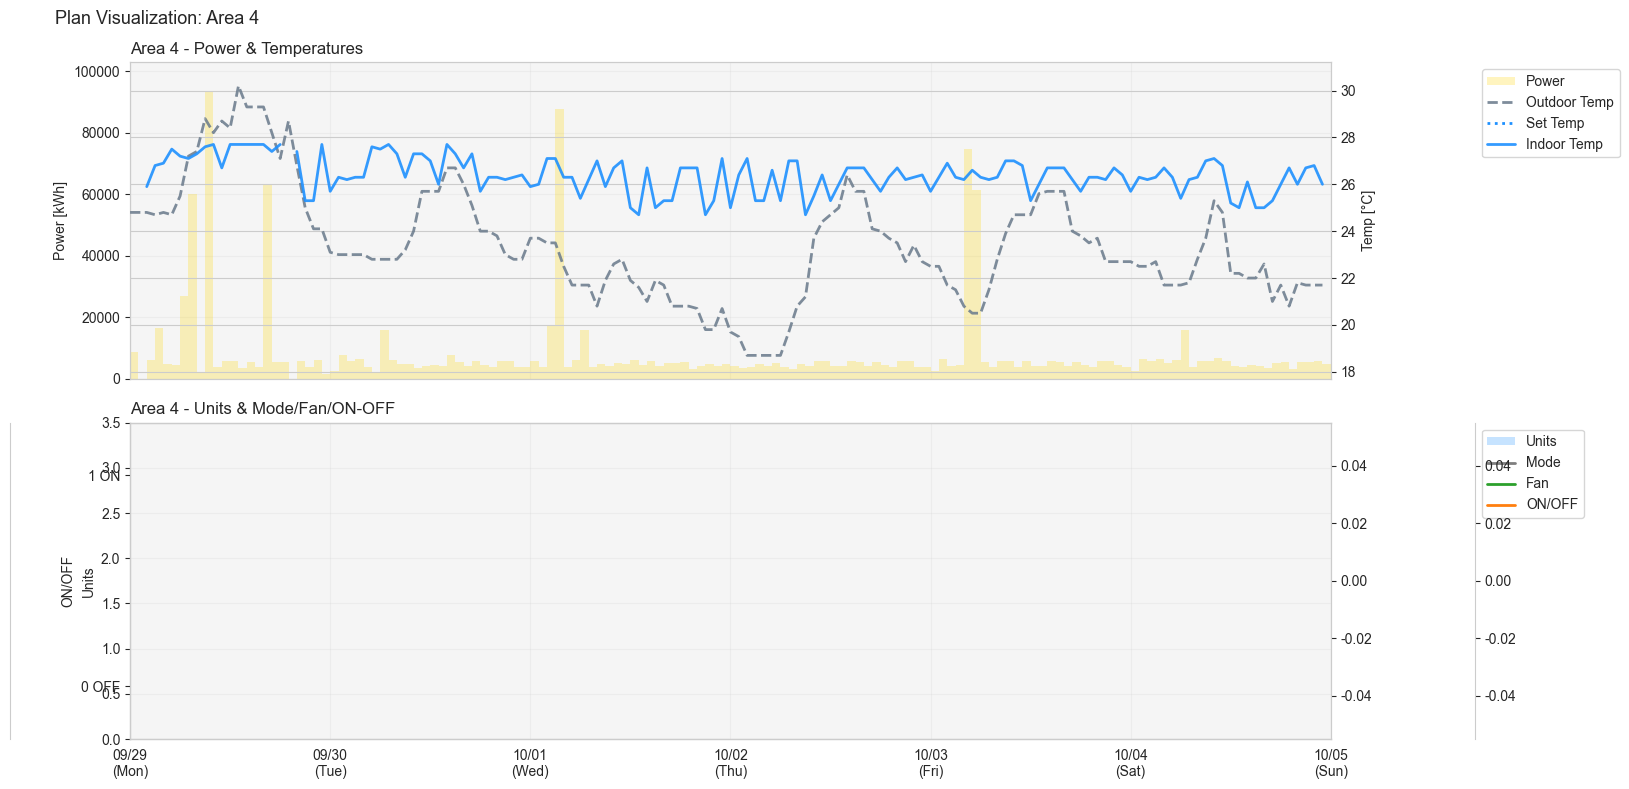

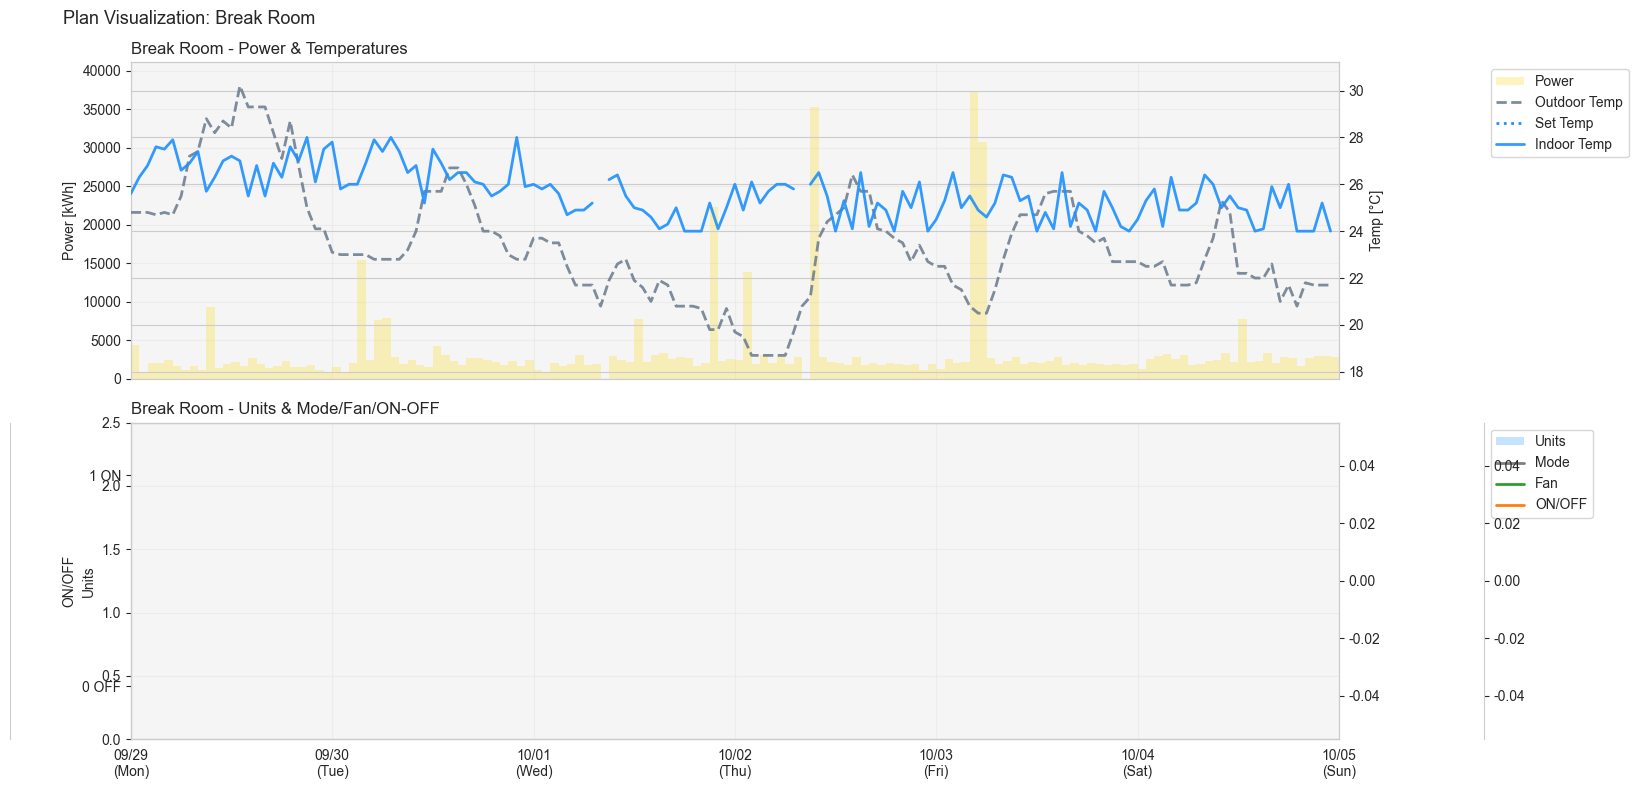

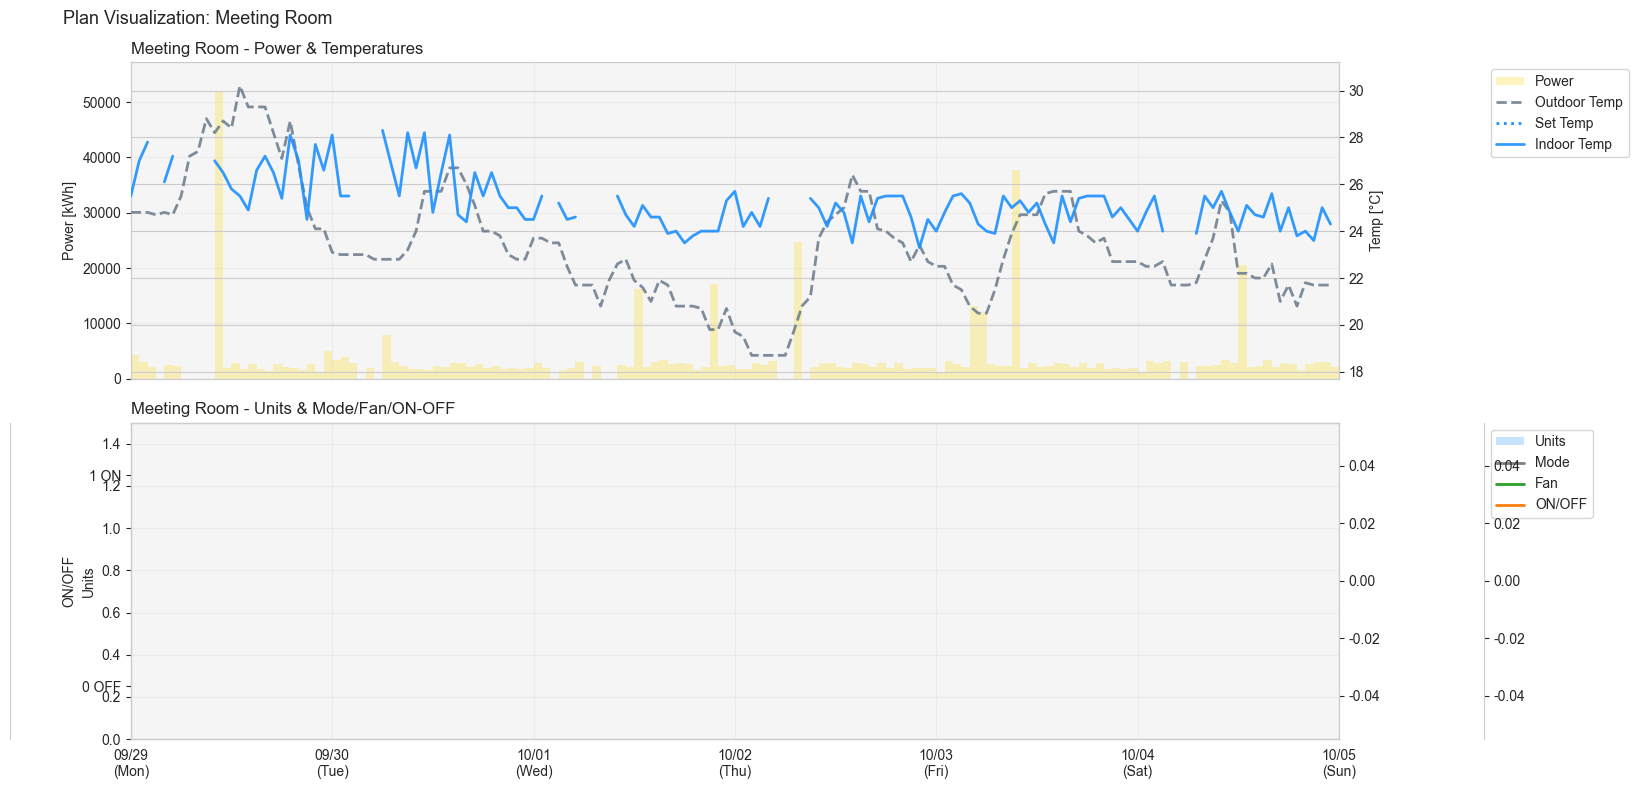

In [6]:
# 実行セル: 計画CSVを読み込み、全ゾーンを同スタイルで一括可視化

# ここを書き換えて使う
results_csv = str(project_root / "data/04_PlanningData/Clea/optimized_results_20250929_20251004.csv")
start_filter = ''  # 例: '2025-09-29'
end_filter   = ''  # 例: '2025-10-04'

# 読み込み
plan_df = pd.read_csv(results_csv)
if 'datetime' in plan_df.columns:
    plan_df['datetime'] = pd.to_datetime(plan_df['datetime'])
elif 'Datetime' in plan_df.columns:
    plan_df['datetime'] = pd.to_datetime(plan_df['Datetime'])
else:
    raise ValueError('datetime列が見つかりません')

# ゾーン推定
zones_plan = infer_zones(plan_df.columns.tolist())
print(f"✅ 読み込み成功: {plan_df.shape}, ゾーン: {zones_plan}")

# 全ゾーン可視化
for z in zones_plan:
    plot_zone_plan_styled(plan_df, z, start_filter, end_filter)


✅ 読み込み成功: (144, 75), ゾーン: ['Area 1', 'Area 2', 'Area 3', 'Area 4', 'Break Room', 'Meeting Room']


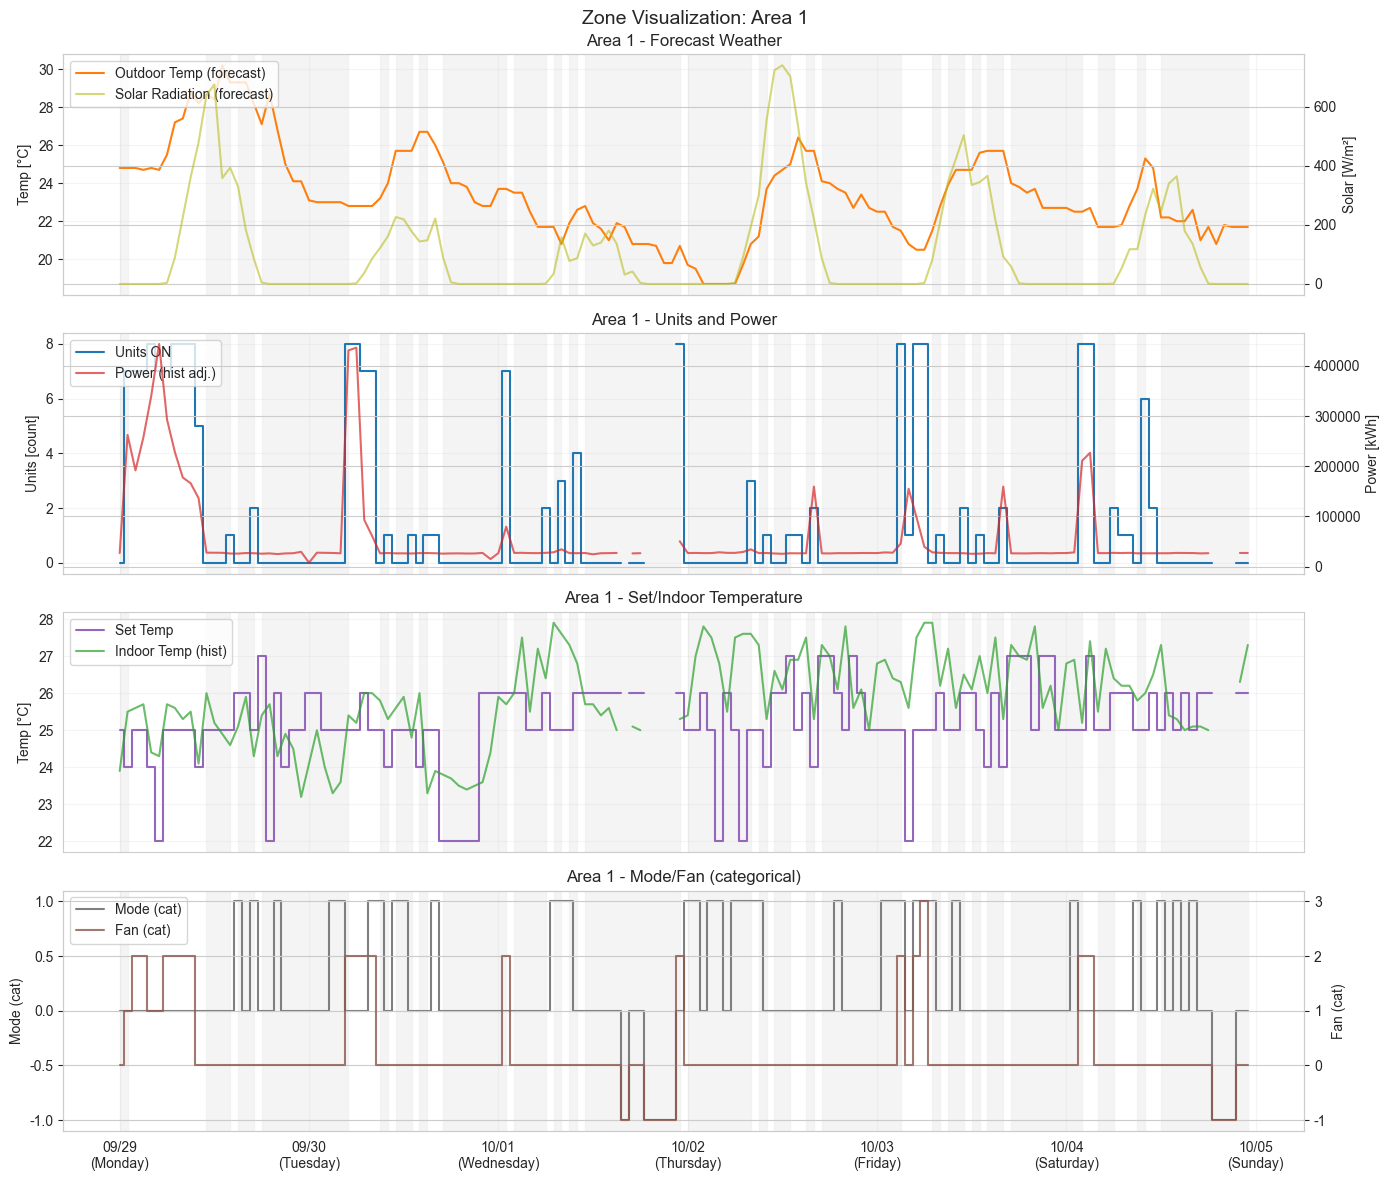

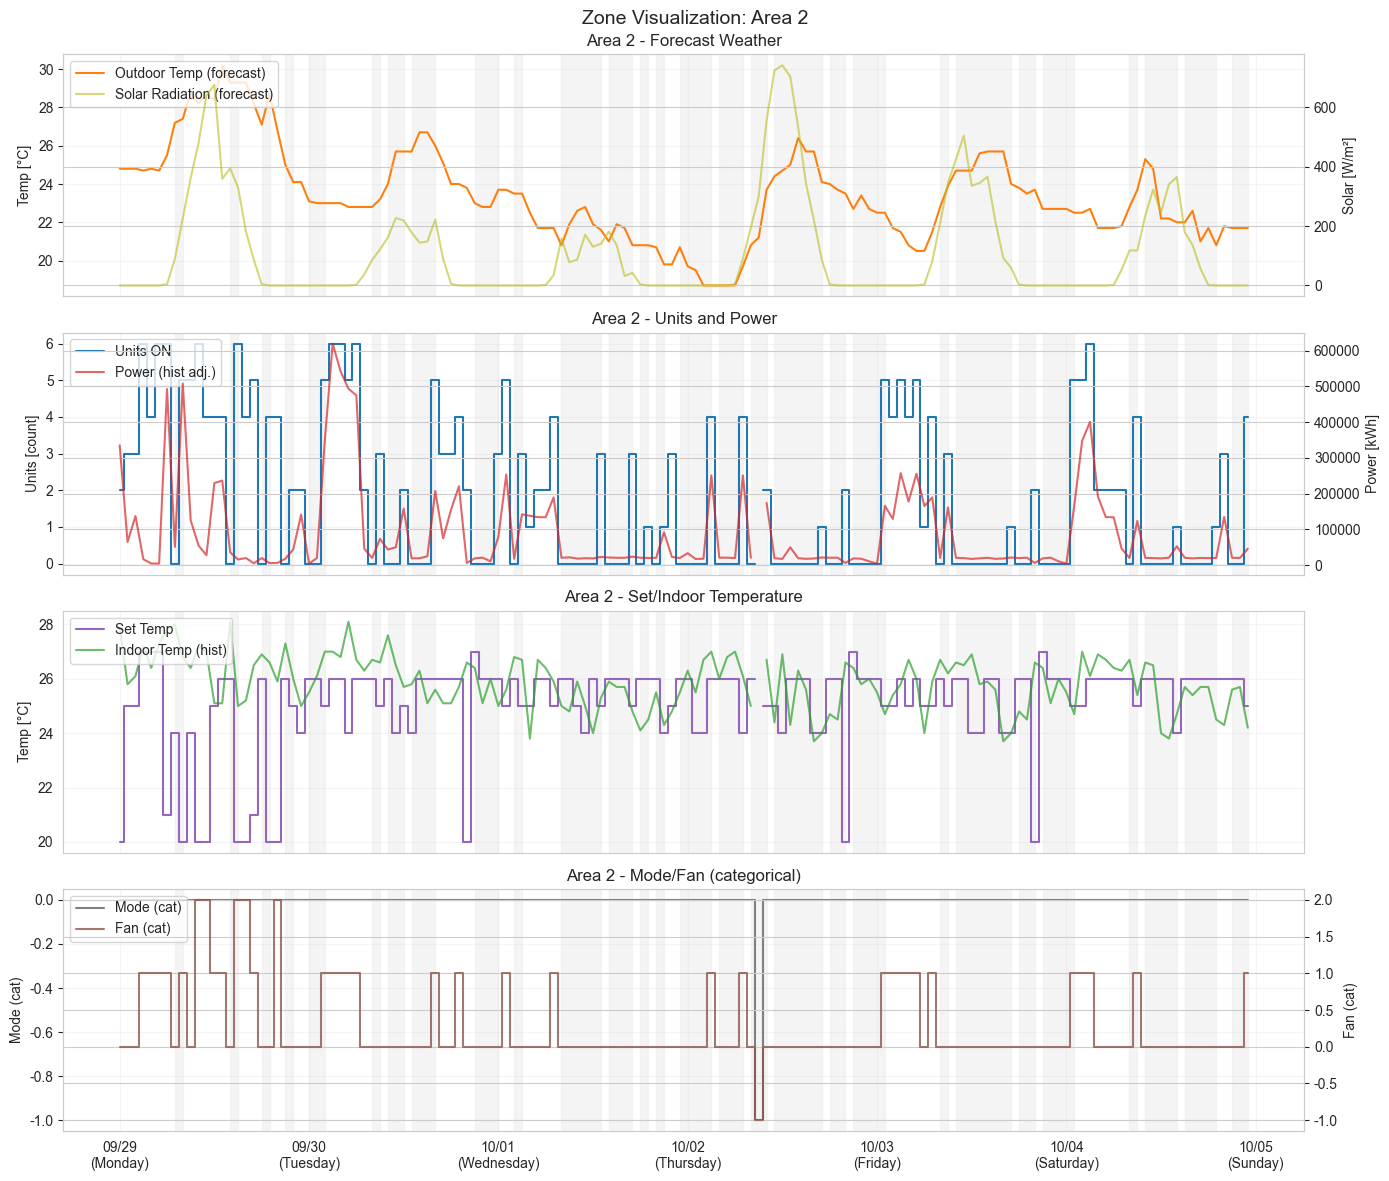

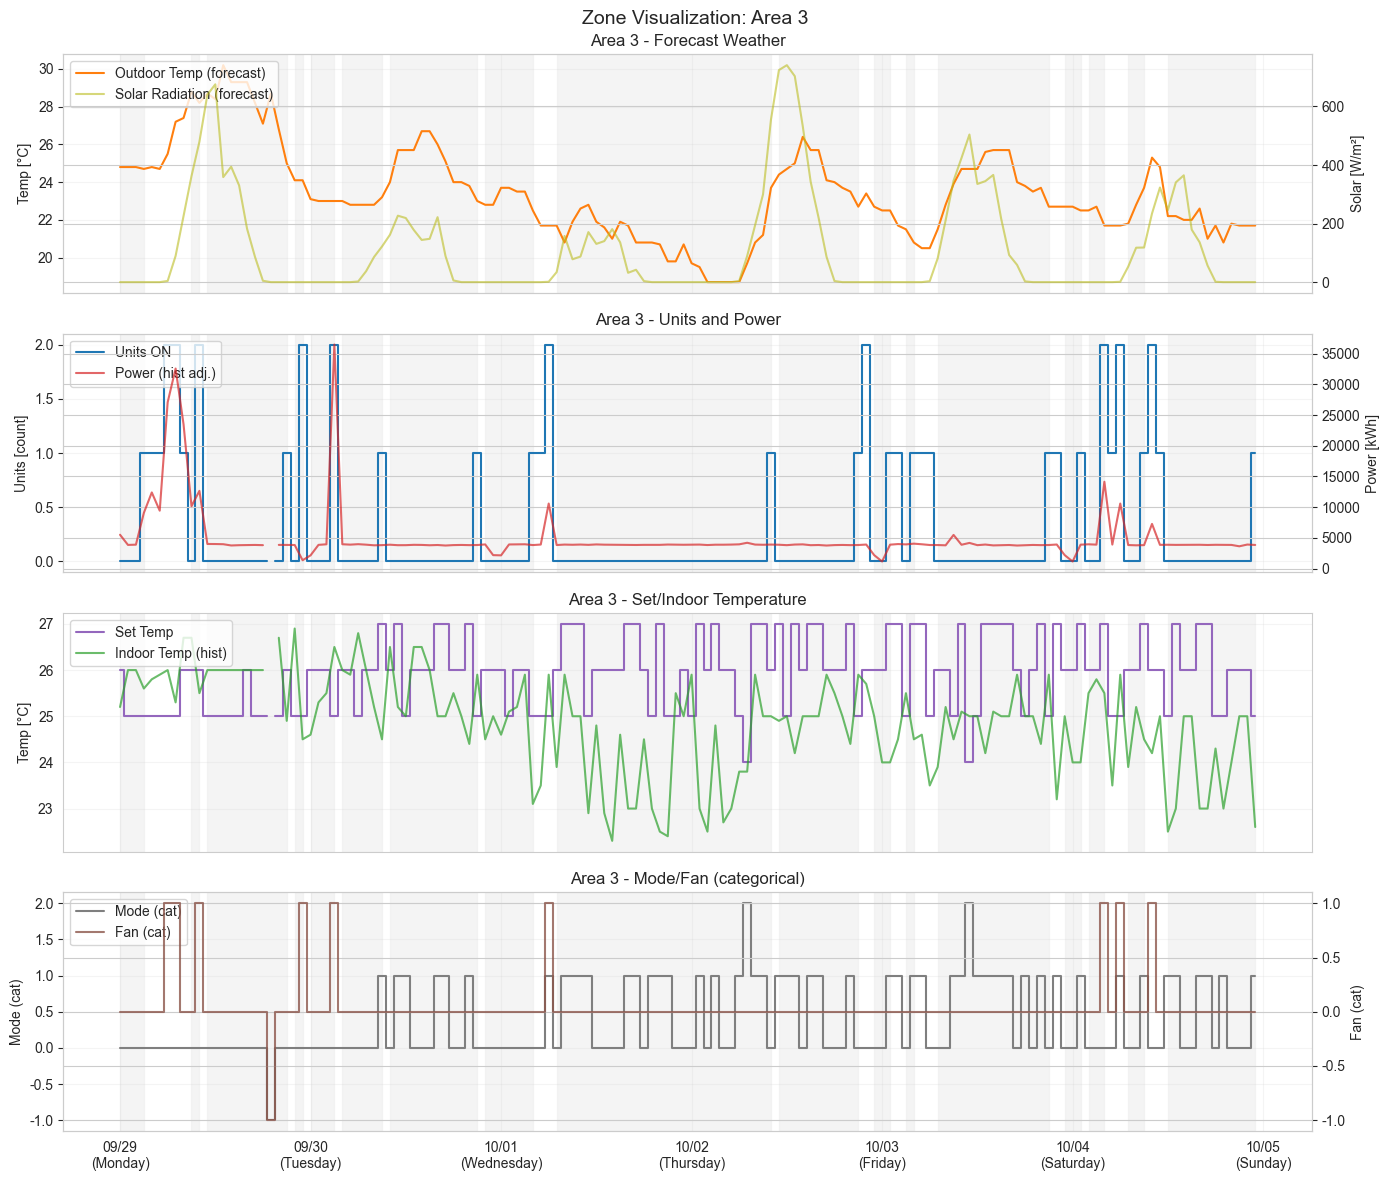

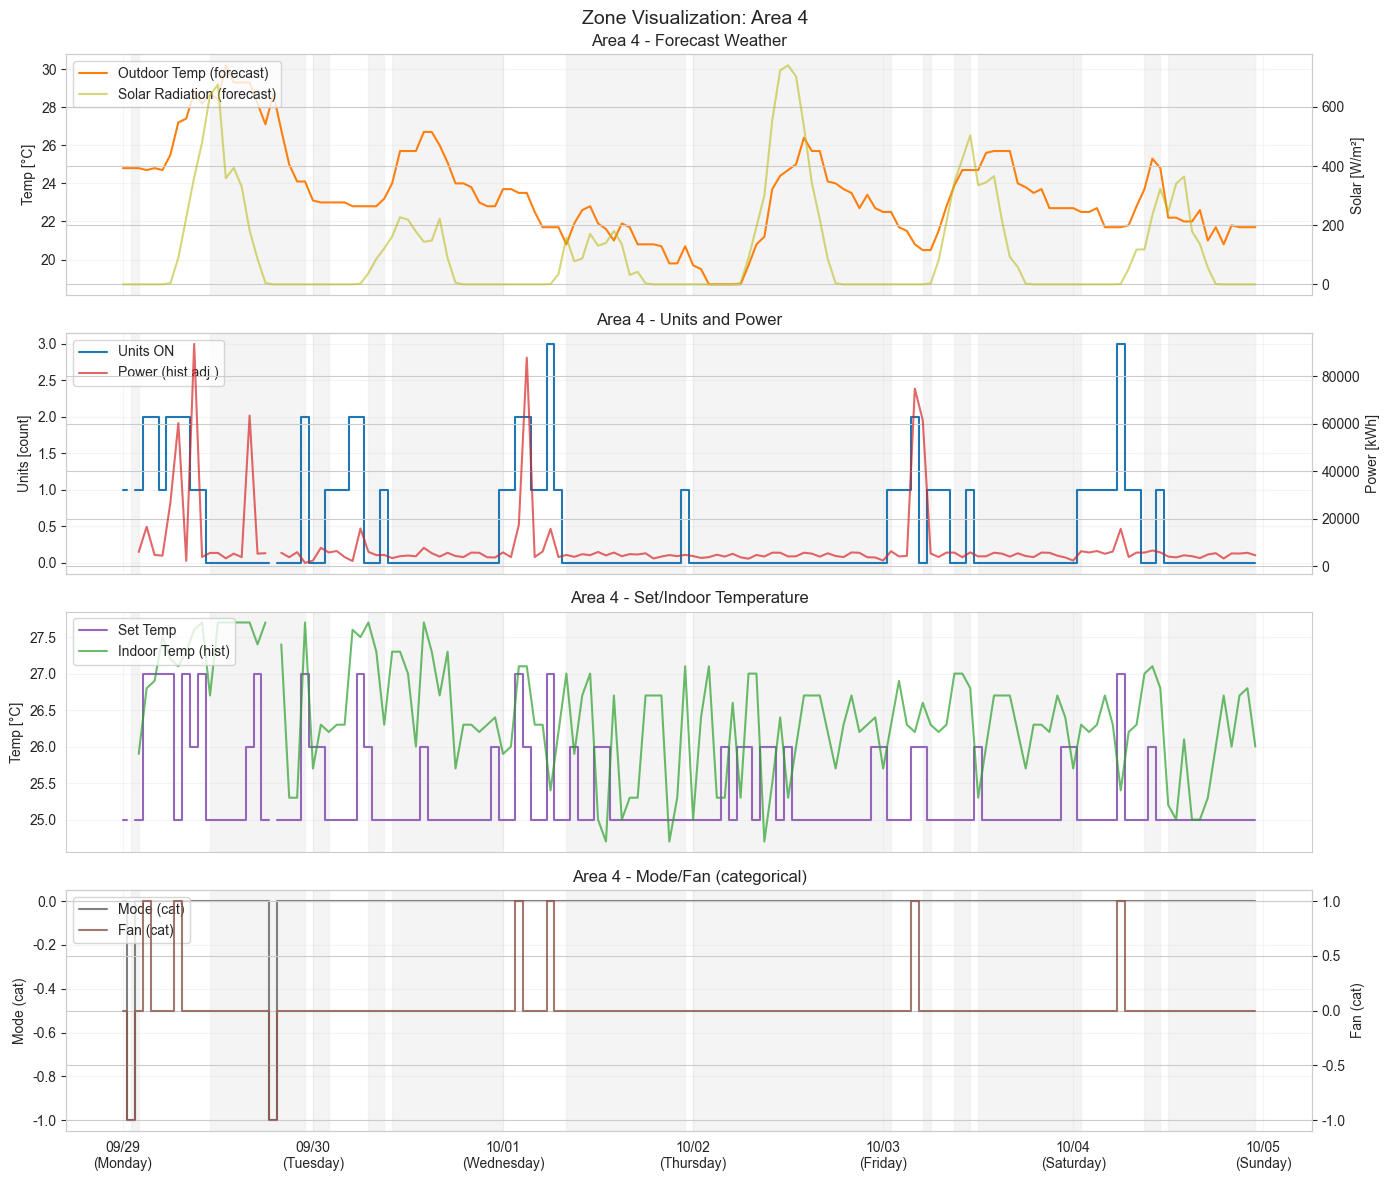

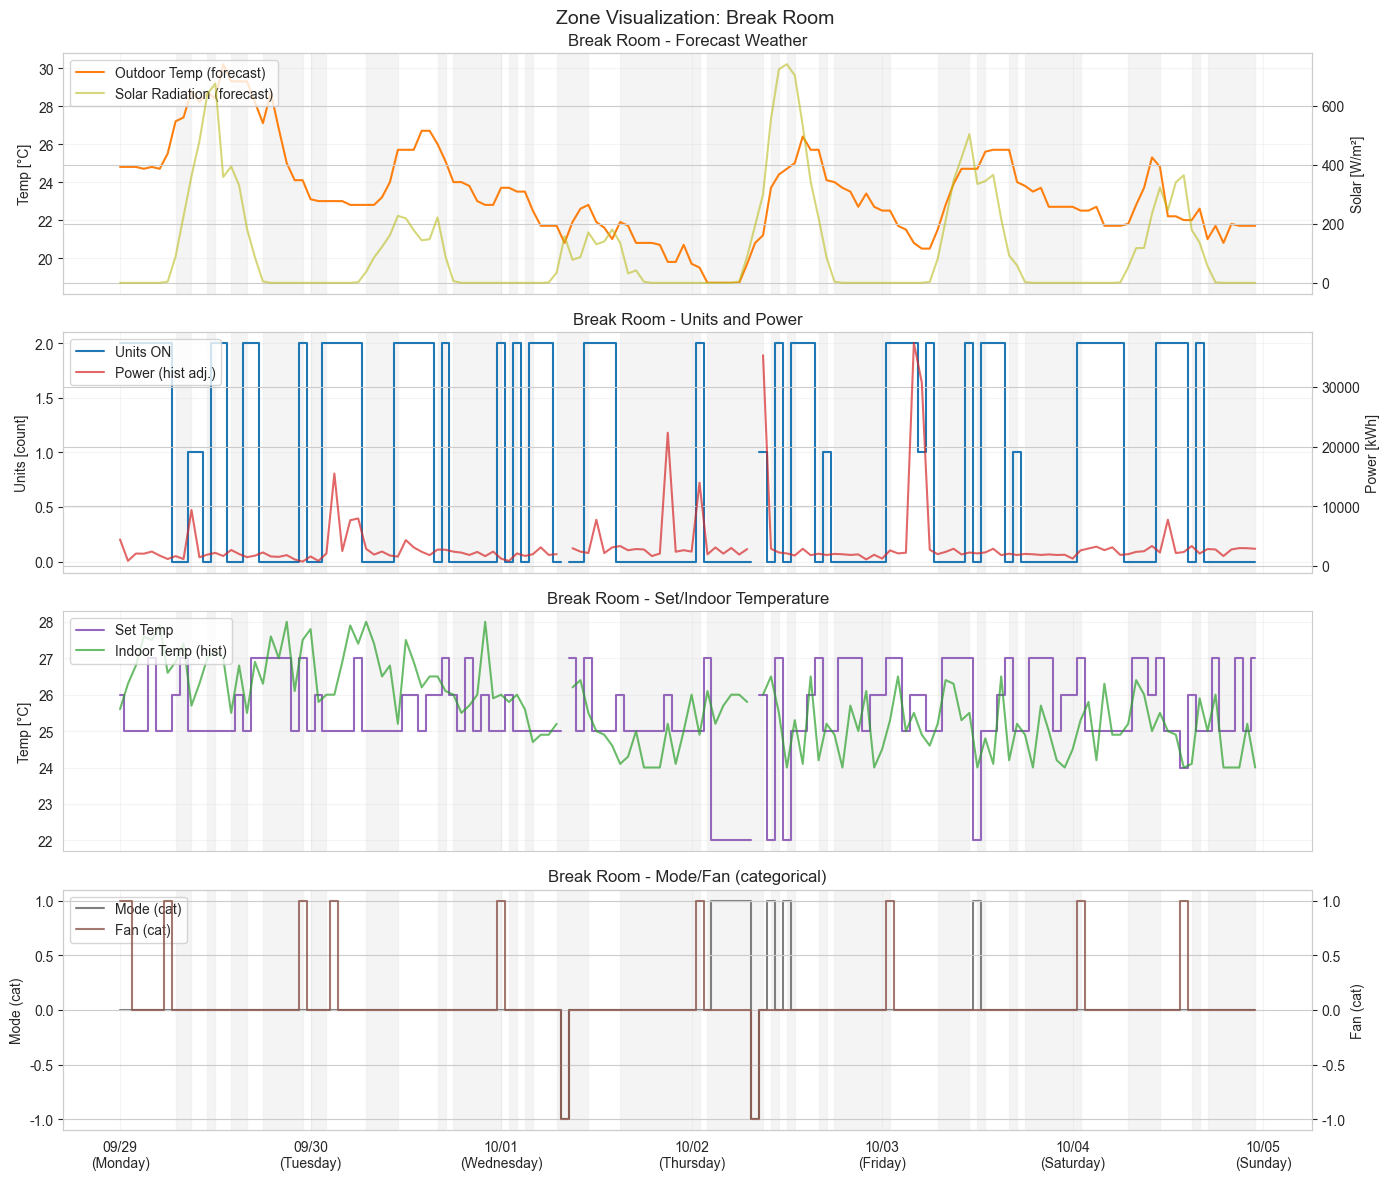

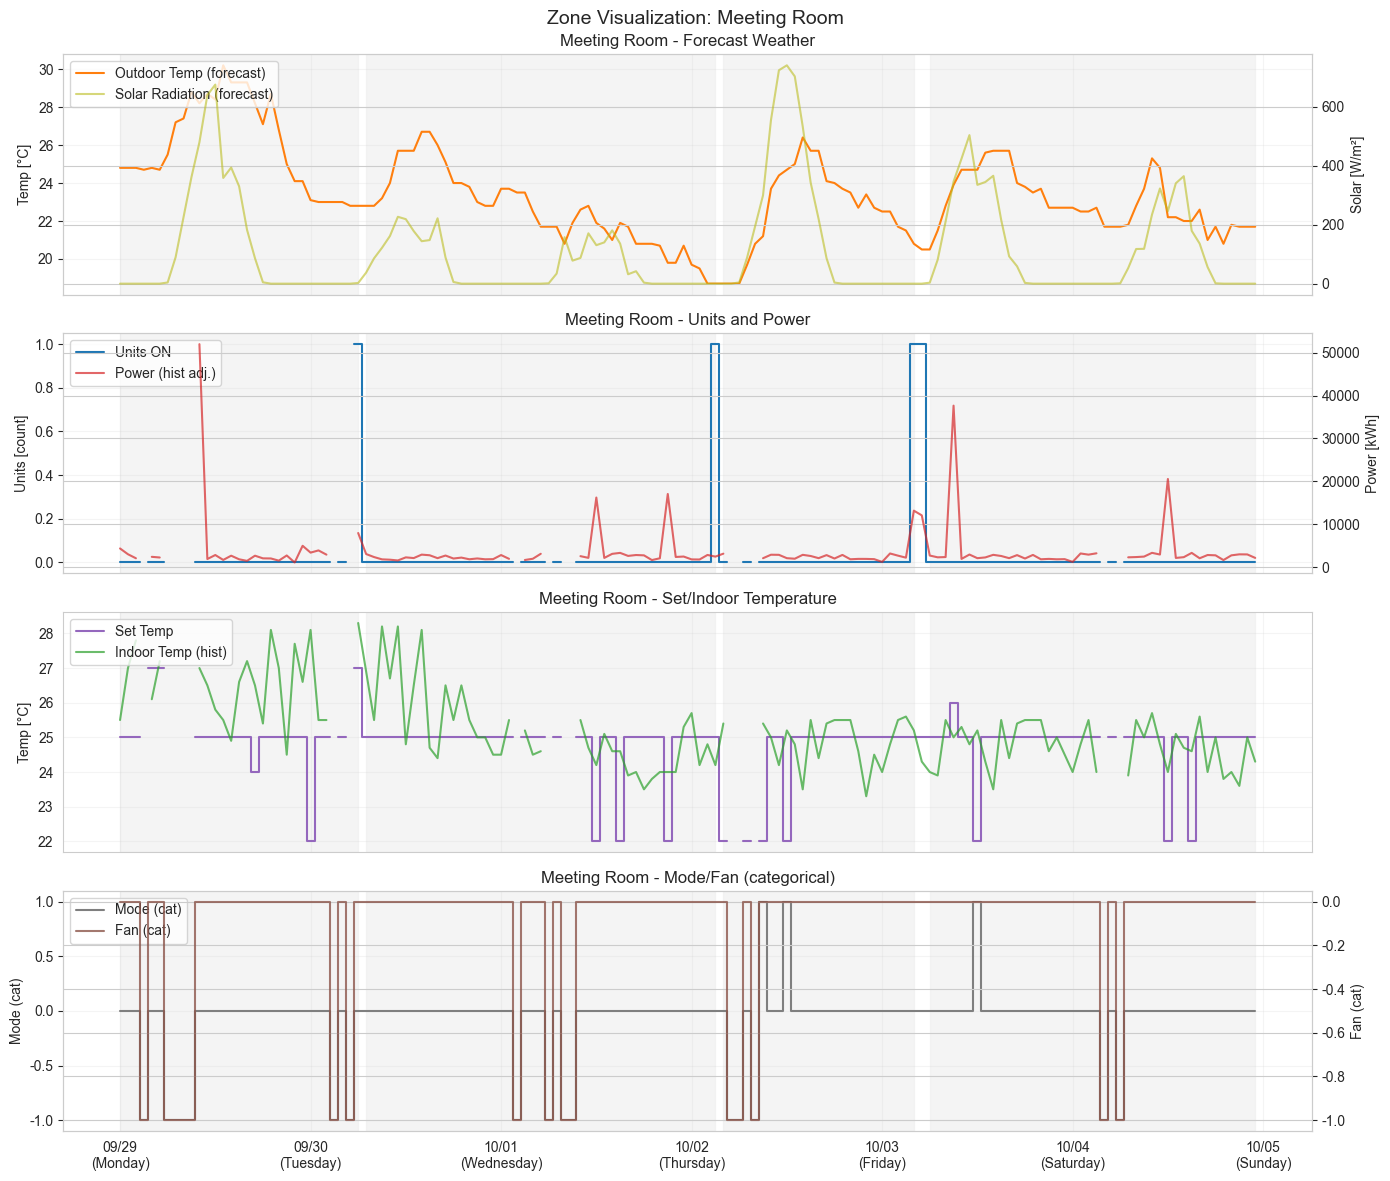

In [7]:
# 入力不要版: 変数でファイル名を指定し、全ゾーン・全期間を一括可視化

# ここを書き換えて使う
results_csv = str(project_root / "data/04_PlanningData/Clea/optimized_results_20250929_20251004.csv")

# 読み込み
_df = pd.read_csv(results_csv)
if 'datetime' in _df.columns:
    _df['datetime'] = pd.to_datetime(_df['datetime'])
elif 'Datetime' in _df.columns:
    _df['datetime'] = pd.to_datetime(_df['Datetime'])
else:
    raise ValueError('datetime列が見つかりません')

_zones = infer_zones(_df.columns.tolist())
print(f"✅ 読み込み成功: {_df.shape}, ゾーン: {_zones}")

# 全ゾーン・全期間で可視化
for _z in _zones:
    plot_zone(_df, _z)

